In [1]:
import os
import json
import shutil
import tempfile
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import nibabel as nib

from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai import transforms
from monai.transforms import (
    AsDiscrete,
    Activations,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.utils.enums import MetricReduction
from monai.networks.nets import SwinUNETR
from monai import data
from monai.data import decollate_batch
from functools import partial

import torch


print_config()

MONAI version: 0.10.dev2225
Numpy version: 1.22.3
Pytorch version: 1.11.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 6a2067a26b69aee6bcb4cf2b7adcda2c6e9adaed
MONAI __file__: /home/xzhang/anaconda3/envs/monai/lib/python3.9/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.8
Nibabel version: 4.0.1
scikit-image version: 0.19.3
Pillow version: 9.0.1
Tensorboard version: 2.10.0
gdown version: 4.4.0
TorchVision version: 0.12.0
tqdm version: 4.64.0
lmdb version: 1.2.1
psutil version: 5.8.0
pandas version: 1.4.2
einops version: 0.4.1
transformers version: 4.18.0
mlflow version: 1.26.1
pynrrd version: 0.4.2

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## plot figure 1

512 512
65535 16994


(-0.5, 562.5, 562.5, -0.5)

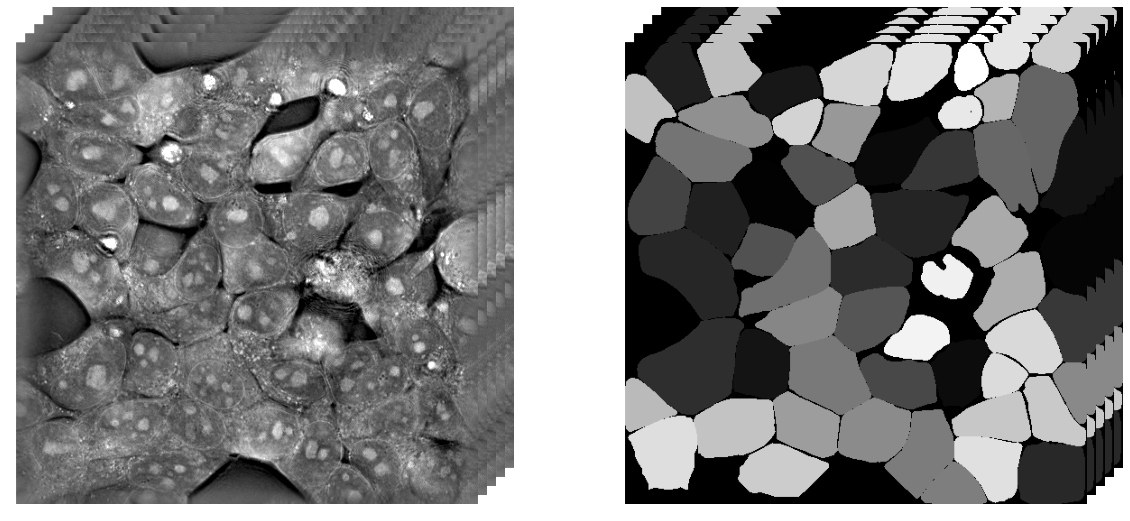

In [18]:
import glob 
import tifffile
import matplotlib.pyplot as plt
import numpy as np
from cellpose_utils import remove_edge_masks,masks_to_edges
from natsort import natsorted
# raw_image_path = '/home/xzhang/Projects/cellpose/Nanolive_mem_cellpose_data_v5_nor_1_99/images/*tiff'
raw_image_path = '/home/xzhang/Projects/cellpose/Nanolive_mem_cellpose_data_v5/images/*tiff'
raw_image_files = natsorted(glob.glob(raw_image_path))
file_idx = 7
raw_image = tifffile.imread(raw_image_files[file_idx])[32,:,:]

label_image_file = natsorted(glob.glob('/home/xzhang/Projects/cellpose/Nanolive_mem_cellpose_data_v5/labels/*tiff'))

label_image = tifffile.imread(label_image_file[file_idx])[32,:,:]
m,n = raw_image.shape
print(m,n)

# print(raw_image.max(),raw_image.min())
# raw_temp = np.ones((553,553),dtype=np.uint16)*65535
# for i in range(4,0,-1):
#     dx = 40-10*i
#     dy = 10*i
#     # print(shift)
#     raw_temp[dx:dx+512,dy:dy+512] = raw_image
# print(label_image.shape )
# print(raw_image.shape)
def make_3d_image(image,shiftx,shifty,Nstep=5,dtype=np.uint16):
    m,n = image.shape
    new_image = np.ones((m+shiftx+1,n+shifty+1),dtype=dtype)*np.iinfo(dtype).max
    for i in range(Nstep,0,-1):
        dx = shiftx -10*i
        dy = 10*i
        new_image[dx:dx+m,dy:dy+n] = image
    return new_image

new_image = make_3d_image(raw_image,50,50) # shift 50, 50 in x y directions
new_label = make_3d_image(label_image,50,50,dtype=np.uint8)
print(new_image.max(),new_image.min())
fig,ax = plt.subplots(1,2, figsize=(20,10))
ax[0].imshow(new_image,cmap='gray',vmin=22000,vmax=32000)
# ax[0].imshow(new_image,cmap='gray',vmin=1,vmax=200)
ax[1].imshow(new_label,cmap='gray',vmin=label_image.min(),vmax=label_image.max())
# ax[2].imshow(raw_image,cmap='gray')
ax[0].axis('off')
ax[1].axis('off')


(4, 96, 512, 512)


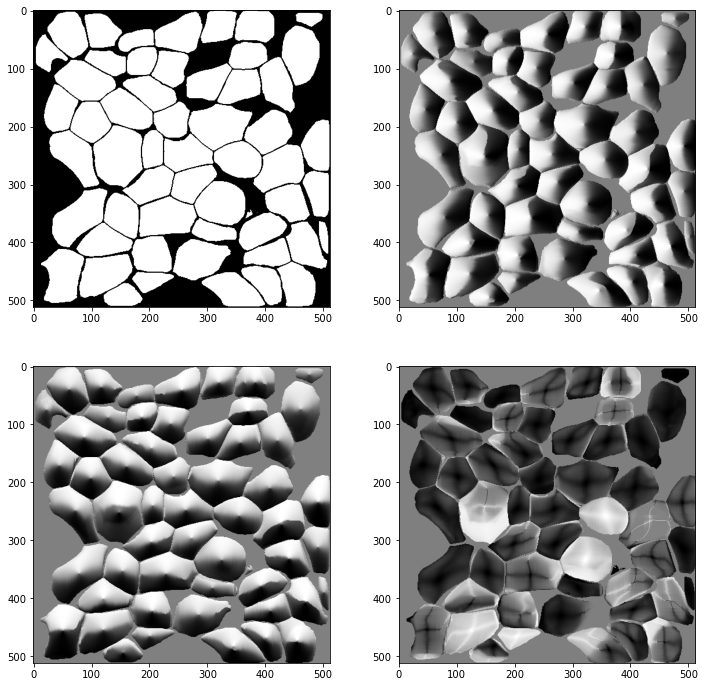

In [19]:
flow_image_file = natsorted(glob.glob('/home/xzhang/Projects/cellpose/Nanolive_mem_cellpose_data_v5_nor_1_99/masks_with_flows/*tiff'))
flow_image = tifffile.imread(flow_image_file[file_idx])
print(flow_image.shape)
if 0: #  delete boundary if boundaries are not deleted yet
    edges = masks_to_edges(flow_image[0].astype(np.uint8)).astype(np.uint8)
    mask_minus_edges = (flow_image[0]>0).astype(np.uint8) - edges
else:
    mask_minus_edges = flow_image[0]

flow_z = flow_image[1]
flow_y = flow_image[2]
flow_x = flow_image[3]

# fig, ax = plt.subplots(1,3, figsize=(20,10))
fig,ax = plt.subplots(2,2, figsize=(12,12))
ax[0][0].imshow(mask_minus_edges[40],cmap='gray')
ax[0][1].imshow(flow_x[40],cmap='gray')
ax[1][0].imshow(flow_y[40],cmap='gray')
ax[1][1].imshow(flow_z[40],cmap='gray')

(96, 512, 512)


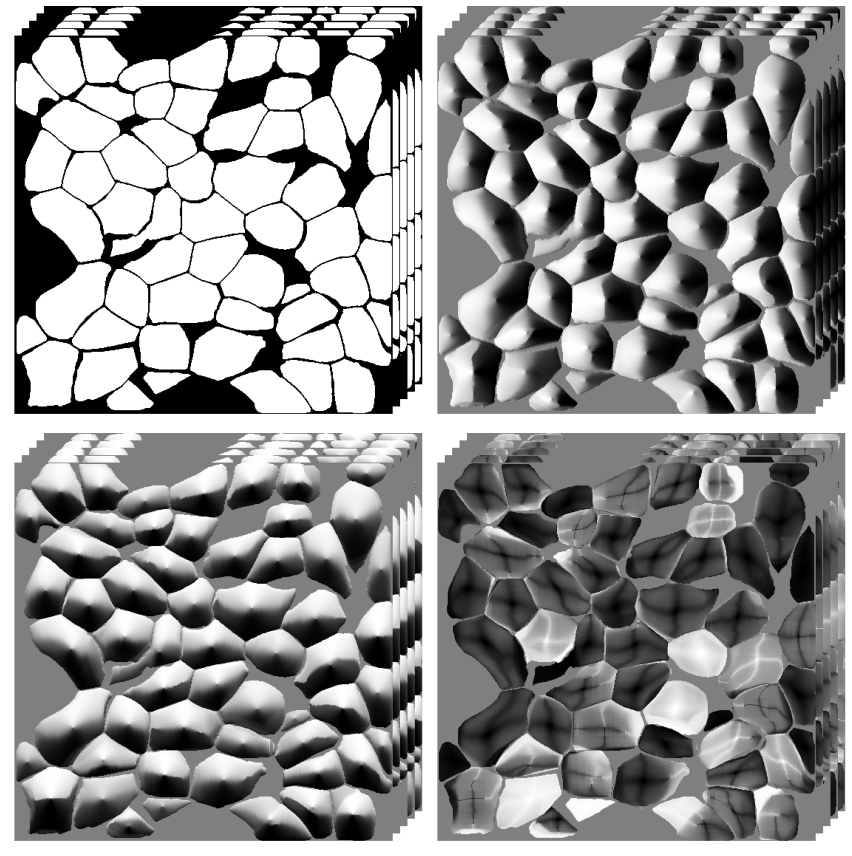

In [20]:
def make_3d_image_3d(image,shiftx,shifty,d_step=10,slice=40,Nstep=5,dtype=np.uint16):
    m,n = image.shape[1:]
    new_image = np.ones((m+shiftx+1,n+shifty+1),dtype=dtype)*np.iinfo(dtype).max
    # new_image = np.ones((m+shiftx+1,n+shifty+1),dtype=dtype)
    for i in range(Nstep,0,-1):
        dx = shiftx -d_step*i
        dy = d_step*i
        new_image[dx:dx+m,dy:dy+n] = image[slice-2*i]
    return new_image

mask_new = make_3d_image_3d(255*mask_minus_edges,50,50,dtype=np.uint8,d_step=10,Nstep=5)
flow_x_new = make_3d_image_3d(flow_x,50,50,dtype=np.uint8,d_step=10,Nstep=5)
flow_y_new = make_3d_image_3d(flow_y,50,50,dtype=np.uint8,d_step=10,Nstep=5)
flow_z_new = make_3d_image_3d(flow_z,50,50,slice=40,dtype=np.uint8)

print(mask_minus_edges.shape)
# flow_x_new = make_3d_image_3d(flow_x,50,50,dtype=np.float64,d_step=10,Nstep=5)
# flow_y_new = make_3d_image_3d(flow_y,50,50,dtype=np.float64,d_step=10,Nstep=5)
# flow_z_new = make_3d_image_3d(flow_z,50,50,slice=40,dtype=np.float64)
fig,ax = plt.subplots(2,2, figsize=(12,12))
ax[0][0].imshow(mask_new,cmap='gray')
ax[0][1].imshow(flow_x_new,cmap='gray')
ax[1][0].imshow(flow_y_new,cmap='gray')
ax[1][1].imshow(flow_z_new,cmap='gray')
ax[0][0].axis('off')
ax[0][1].axis('off')
ax[1][0].axis('off')
ax[1][1].axis('off')

fig.tight_layout()

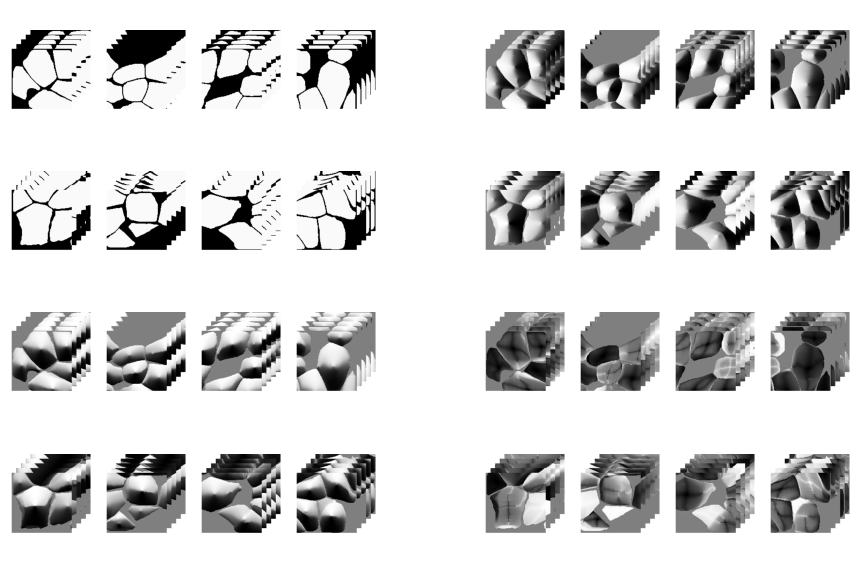

In [21]:
# training patches

mask_new = make_3d_image_3d(255*mask_minus_edges,50,50,dtype=np.uint8,d_step=10,Nstep=5)
flow_x_new = make_3d_image_3d(flow_x,50,50,dtype=np.uint8,d_step=10,Nstep=5)
flow_y_new = make_3d_image_3d(flow_y,50,50,dtype=np.uint8,d_step=10,Nstep=5)
flow_z_new = make_3d_image_3d(flow_z,50,50,slice=40,dtype=np.uint8)
# flow_x_new = make_3d_image_3d(flow_x,50,50,dtype=np.float64,d_step=10,Nstep=5)
# flow_y_new = make_3d_image_3d(flow_y,50,50,dtype=np.float64,d_step=10,Nstep=5)
# flow_z_new = make_3d_image_3d(flow_z,50,50,slice=40,dtype=np.float64)
row = 9
col = 4
step = 128

mask_p1 = make_3d_image_3d(250*mask_minus_edges[:,:128,:128],50,50,dtype=np.uint8,d_step=10,Nstep=5)
mask_p2 = make_3d_image_3d(250*mask_minus_edges[:,:128,128*1:128*2],50,50,dtype=np.uint8,d_step=10,Nstep=5)
mask_p3 = make_3d_image_3d(250*mask_minus_edges[:,:128,128*2:128*3],50,50,dtype=np.uint8,d_step=10,Nstep=5)
mask_p4 = make_3d_image_3d(250*mask_minus_edges[:,:128,128*3:128*4],50,50,dtype=np.uint8,d_step=10,Nstep=5)

fig,ax = plt.subplots(col ,row, figsize=(12,8))
ax[0][0].imshow(mask_p1,cmap='gray')
ax[0][1].imshow(mask_p2,cmap='gray')
ax[0][2].imshow(mask_p3,cmap='gray')
ax[0][3].imshow(mask_p4,cmap='gray')
#-------------------------------
flowx_p1 = make_3d_image_3d(flow_x[:,:128,:128],50,50,dtype=np.uint8,d_step=10,Nstep=5)
flowx_p2 = make_3d_image_3d(flow_x[:,:128,128*1:128*2],50,50,dtype=np.uint8,d_step=10,Nstep=5)
flowx_p3 = make_3d_image_3d(flow_x[:,:128,128*2:128*3],50,50,dtype=np.uint8,d_step=10,Nstep=5)
flowx_p4 = make_3d_image_3d(flow_x[:,:128,128*3:128*4],50,50,dtype=np.uint8,d_step=10,Nstep=5)

ax[0][5].imshow(flowx_p1,cmap='gray')
ax[0][6].imshow(flowx_p2,cmap='gray')
ax[0][7].imshow(flowx_p3,cmap='gray')
ax[0][8].imshow(flowx_p4,cmap='gray')
#-------------------------------------------------------
mask_p5 = make_3d_image_3d(250*mask_minus_edges[:,128*3:,:128],50,50,dtype=np.uint8,d_step=10,Nstep=5)
mask_p6 = make_3d_image_3d(250*mask_minus_edges[:,128*3:,128*1:128*2],50,50,dtype=np.uint8,d_step=10,Nstep=5)
mask_p7 = make_3d_image_3d(250*mask_minus_edges[:,128*3:,128*2:128*3],50,50,dtype=np.uint8,d_step=10,Nstep=5)
mask_p8 = make_3d_image_3d(250*mask_minus_edges[:,128*3:,128*3:128*4],50,50,dtype=np.uint8,d_step=10,Nstep=5)


ax[1][0].imshow(mask_p5,cmap='gray')
ax[1][1].imshow(mask_p6,cmap='gray')
ax[1][2].imshow(mask_p7,cmap='gray')
ax[1][3].imshow(mask_p8,cmap='gray')

flowx_p5 = make_3d_image_3d(flow_x[:,128*3:,:128],50,50,dtype=np.uint8,d_step=10,Nstep=5)
flowx_p6 = make_3d_image_3d(flow_x[:,128*3:,128*1:128*2],50,50,dtype=np.uint8,d_step=10,Nstep=5)
flowx_p7 = make_3d_image_3d(flow_x[:,128*3:,128*2:128*3],50,50,dtype=np.uint8,d_step=10,Nstep=5)
flowx_p8 = make_3d_image_3d(flow_x[:,128*3:,128*3:128*4],50,50,dtype=np.uint8,d_step=10,Nstep=5)

ax[1][5].imshow(flowx_p5,cmap='gray')
ax[1][6].imshow(flowx_p6,cmap='gray')
ax[1][7].imshow(flowx_p7,cmap='gray')
ax[1][8].imshow(flowx_p8,cmap='gray')
#--------------------------------------------------------


flowy_p1 = make_3d_image_3d(flow_y[:,:128,:128],50,50,dtype=np.uint8,d_step=10,Nstep=5)
flowy_p2 = make_3d_image_3d(flow_y[:,:128,128*1:128*2],50,50,dtype=np.uint8,d_step=10,Nstep=5)
flowy_p3 = make_3d_image_3d(flow_y[:,:128,128*2:128*3],50,50,dtype=np.uint8,d_step=10,Nstep=5)
flowy_p4 = make_3d_image_3d(flow_y[:,:128,128*3:128*4],50,50,dtype=np.uint8,d_step=10,Nstep=5)

flowy_p5 = make_3d_image_3d(flow_y[:,128*3:,:128],50,50,dtype=np.uint8,d_step=10,Nstep=5)
flowy_p6 = make_3d_image_3d(flow_y[:,128*3:,128*1:128*2],50,50,dtype=np.uint8,d_step=10,Nstep=5)
flowy_p7 = make_3d_image_3d(flow_y[:,128*3:,128*2:128*3],50,50,dtype=np.uint8,d_step=10,Nstep=5)
flowy_p8 = make_3d_image_3d(flow_y[:,128*3:,128*3:128*4],50,50,dtype=np.uint8,d_step=10,Nstep=5)

ax[2][0].imshow(flowy_p1,cmap='gray')
ax[2][1].imshow(flowy_p2,cmap='gray')
ax[2][2].imshow(flowy_p3,cmap='gray')
ax[2][3].imshow(flowy_p4,cmap='gray')

ax[3][0].imshow(flowy_p5,cmap='gray')
ax[3][1].imshow(flowy_p6,cmap='gray')
ax[3][2].imshow(flowy_p7,cmap='gray')
ax[3][3].imshow(flowy_p8,cmap='gray')
#----------------------------

flowz_p1 = make_3d_image_3d(flow_z[:,:128,:128],50,50,dtype=np.uint8,d_step=10,Nstep=5)
flowz_p2 = make_3d_image_3d(flow_z[:,:128,128*1:128*2],50,50,dtype=np.uint8,d_step=10,Nstep=5)
flowz_p3 = make_3d_image_3d(flow_z[:,:128,128*2:128*3],50,50,dtype=np.uint8,d_step=10,Nstep=5)
flowz_p4 = make_3d_image_3d(flow_z[:,:128,128*3:128*4],50,50,dtype=np.uint8,d_step=10,Nstep=5)

flowz_p5 = make_3d_image_3d(flow_z[:,128*3:,:128],50,50,dtype=np.uint8,d_step=10,Nstep=5)
flowz_p6 = make_3d_image_3d(flow_z[:,128*3:,128*1:128*2],50,50,dtype=np.uint8,d_step=10,Nstep=5)
flowz_p7 = make_3d_image_3d(flow_z[:,128*3:,128*2:128*3],50,50,dtype=np.uint8,d_step=10,Nstep=5)
flowz_p8 = make_3d_image_3d(flow_z[:,128*3:,128*3:128*4],50,50,dtype=np.uint8,d_step=10,Nstep=5)

ax[2][5].imshow(flowz_p1,cmap='gray')
ax[2][6].imshow(flowz_p2,cmap='gray')
ax[2][7].imshow(flowz_p3,cmap='gray')
ax[2][8].imshow(flowz_p4,cmap='gray')



ax[3][5].imshow(flowz_p5,cmap='gray')
ax[3][6].imshow(flowz_p6,cmap='gray')
ax[3][7].imshow(flowz_p7,cmap='gray')
ax[3][8].imshow(flowz_p8,cmap='gray')


for i in range(row): 
    for j in range(col):
        ax[j][i].axis('off')

fig.tight_layout()

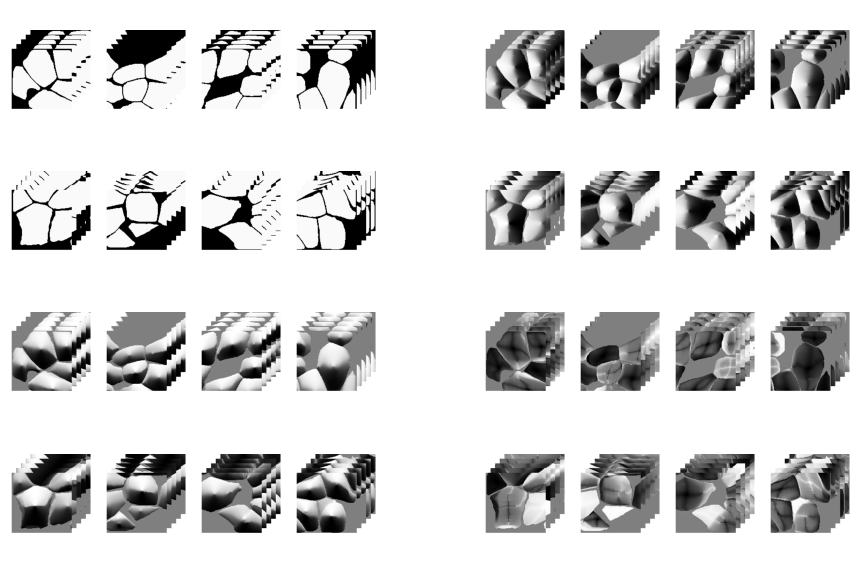

In [22]:
# training patches

mask_new = make_3d_image_3d(255*mask_minus_edges,50,50,dtype=np.uint8,d_step=10,Nstep=5)
flow_x_new = make_3d_image_3d(flow_x,50,50,dtype=np.uint8,d_step=10,Nstep=5)
flow_y_new = make_3d_image_3d(flow_y,50,50,dtype=np.uint8,d_step=10,Nstep=5)
flow_z_new = make_3d_image_3d(flow_z,50,50,slice=40,dtype=np.uint8)
# flow_x_new = make_3d_image_3d(flow_x,50,50,dtype=np.float64,d_step=10,Nstep=5)
# flow_y_new = make_3d_image_3d(flow_y,50,50,dtype=np.float64,d_step=10,Nstep=5)
# flow_z_new = make_3d_image_3d(flow_z,50,50,slice=40,dtype=np.float64)
row = 9
col = 4
step = 128

mask_p1 = make_3d_image_3d(250*mask_minus_edges[:,:128,:128],50,50,dtype=np.uint8,d_step=10,Nstep=5)
mask_p2 = make_3d_image_3d(250*mask_minus_edges[:,:128,128*1:128*2],50,50,dtype=np.uint8,d_step=10,Nstep=5)
mask_p3 = make_3d_image_3d(250*mask_minus_edges[:,:128,128*2:128*3],50,50,dtype=np.uint8,d_step=10,Nstep=5)
mask_p4 = make_3d_image_3d(250*mask_minus_edges[:,:128,128*3:128*4],50,50,dtype=np.uint8,d_step=10,Nstep=5)

fig,ax = plt.subplots(col ,row, figsize=(12,8))
ax[0][0].imshow(mask_p1,cmap='gray')
ax[0][1].imshow(mask_p2,cmap='gray')
ax[0][2].imshow(mask_p3,cmap='gray')
ax[0][3].imshow(mask_p4,cmap='gray')
#-------------------------------
flowx_p1 = make_3d_image_3d(flow_x[:,:128,:128],50,50,dtype=np.uint8,d_step=10,Nstep=5)
flowx_p2 = make_3d_image_3d(flow_x[:,:128,128*1:128*2],50,50,dtype=np.uint8,d_step=10,Nstep=5)
flowx_p3 = make_3d_image_3d(flow_x[:,:128,128*2:128*3],50,50,dtype=np.uint8,d_step=10,Nstep=5)
flowx_p4 = make_3d_image_3d(flow_x[:,:128,128*3:128*4],50,50,dtype=np.uint8,d_step=10,Nstep=5)

ax[0][5].imshow(flowx_p1,cmap='gray')
ax[0][6].imshow(flowx_p2,cmap='gray')
ax[0][7].imshow(flowx_p3,cmap='gray')
ax[0][8].imshow(flowx_p4,cmap='gray')
#-------------------------------------------------------
mask_p5 = make_3d_image_3d(250*mask_minus_edges[:,128*3:,:128],50,50,dtype=np.uint8,d_step=10,Nstep=5)
mask_p6 = make_3d_image_3d(250*mask_minus_edges[:,128*3:,128*1:128*2],50,50,dtype=np.uint8,d_step=10,Nstep=5)
mask_p7 = make_3d_image_3d(250*mask_minus_edges[:,128*3:,128*2:128*3],50,50,dtype=np.uint8,d_step=10,Nstep=5)
mask_p8 = make_3d_image_3d(250*mask_minus_edges[:,128*3:,128*3:128*4],50,50,dtype=np.uint8,d_step=10,Nstep=5)


ax[1][0].imshow(mask_p5,cmap='gray')
ax[1][1].imshow(mask_p6,cmap='gray')
ax[1][2].imshow(mask_p7,cmap='gray')
ax[1][3].imshow(mask_p8,cmap='gray')

flowx_p5 = make_3d_image_3d(flow_x[:,128*3:,:128],50,50,dtype=np.uint8,d_step=10,Nstep=5)
flowx_p6 = make_3d_image_3d(flow_x[:,128*3:,128*1:128*2],50,50,dtype=np.uint8,d_step=10,Nstep=5)
flowx_p7 = make_3d_image_3d(flow_x[:,128*3:,128*2:128*3],50,50,dtype=np.uint8,d_step=10,Nstep=5)
flowx_p8 = make_3d_image_3d(flow_x[:,128*3:,128*3:128*4],50,50,dtype=np.uint8,d_step=10,Nstep=5)

ax[1][5].imshow(flowx_p5,cmap='gray')
ax[1][6].imshow(flowx_p6,cmap='gray')
ax[1][7].imshow(flowx_p7,cmap='gray')
ax[1][8].imshow(flowx_p8,cmap='gray')
#--------------------------------------------------------


flowy_p1 = make_3d_image_3d(flow_y[:,:128,:128],50,50,dtype=np.uint8,d_step=10,Nstep=5)
flowy_p2 = make_3d_image_3d(flow_y[:,:128,128*1:128*2],50,50,dtype=np.uint8,d_step=10,Nstep=5)
flowy_p3 = make_3d_image_3d(flow_y[:,:128,128*2:128*3],50,50,dtype=np.uint8,d_step=10,Nstep=5)
flowy_p4 = make_3d_image_3d(flow_y[:,:128,128*3:128*4],50,50,dtype=np.uint8,d_step=10,Nstep=5)

flowy_p5 = make_3d_image_3d(flow_y[:,128*3:,:128],50,50,dtype=np.uint8,d_step=10,Nstep=5)
flowy_p6 = make_3d_image_3d(flow_y[:,128*3:,128*1:128*2],50,50,dtype=np.uint8,d_step=10,Nstep=5)
flowy_p7 = make_3d_image_3d(flow_y[:,128*3:,128*2:128*3],50,50,dtype=np.uint8,d_step=10,Nstep=5)
flowy_p8 = make_3d_image_3d(flow_y[:,128*3:,128*3:128*4],50,50,dtype=np.uint8,d_step=10,Nstep=5)

ax[2][0].imshow(flowy_p1,cmap='gray')
ax[2][1].imshow(flowy_p2,cmap='gray')
ax[2][2].imshow(flowy_p3,cmap='gray')
ax[2][3].imshow(flowy_p4,cmap='gray')

ax[3][0].imshow(flowy_p5,cmap='gray')
ax[3][1].imshow(flowy_p6,cmap='gray')
ax[3][2].imshow(flowy_p7,cmap='gray')
ax[3][3].imshow(flowy_p8,cmap='gray')
#----------------------------

flowz_p1 = make_3d_image_3d(flow_z[:,:128,:128],50,50,dtype=np.uint8,d_step=10,Nstep=5)
flowz_p2 = make_3d_image_3d(flow_z[:,:128,128*1:128*2],50,50,dtype=np.uint8,d_step=10,Nstep=5)
flowz_p3 = make_3d_image_3d(flow_z[:,:128,128*2:128*3],50,50,dtype=np.uint8,d_step=10,Nstep=5)
flowz_p4 = make_3d_image_3d(flow_z[:,:128,128*3:128*4],50,50,dtype=np.uint8,d_step=10,Nstep=5)

flowz_p5 = make_3d_image_3d(flow_z[:,128*3:,:128],50,50,dtype=np.uint8,d_step=10,Nstep=5)
flowz_p6 = make_3d_image_3d(flow_z[:,128*3:,128*1:128*2],50,50,dtype=np.uint8,d_step=10,Nstep=5)
flowz_p7 = make_3d_image_3d(flow_z[:,128*3:,128*2:128*3],50,50,dtype=np.uint8,d_step=10,Nstep=5)
flowz_p8 = make_3d_image_3d(flow_z[:,128*3:,128*3:128*4],50,50,dtype=np.uint8,d_step=10,Nstep=5)

ax[2][5].imshow(flowz_p1,cmap='gray')
ax[2][6].imshow(flowz_p2,cmap='gray')
ax[2][7].imshow(flowz_p3,cmap='gray')
ax[2][8].imshow(flowz_p4,cmap='gray')



ax[3][5].imshow(flowz_p5,cmap='gray')
ax[3][6].imshow(flowz_p6,cmap='gray')
ax[3][7].imshow(flowz_p7,cmap='gray')
ax[3][8].imshow(flowz_p8,cmap='gray')


for i in range(row): 
    for j in range(col):
        ax[j][i].axis('off')

fig.tight_layout()

# section N, test ploting color flows instead of gray scale flows

(96, 512, 512)


Text(0.5, 1.0, 'Spatial Gradient')

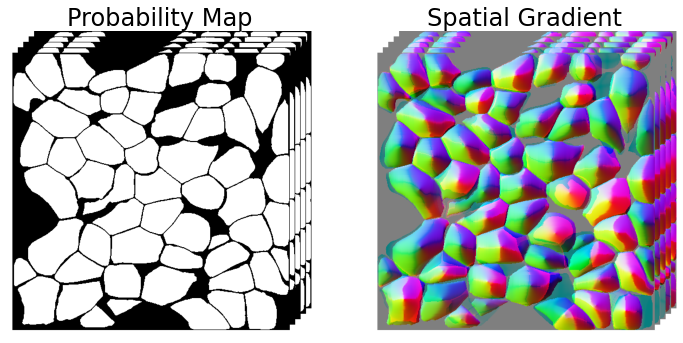

In [54]:
mask_new = make_3d_image_3d(255*mask_minus_edges,50,50,dtype=np.uint8,d_step=10,Nstep=5)
flow_x_new = make_3d_image_3d(flow_x,50,50,dtype=np.uint8,d_step=10,Nstep=5)
flow_y_new = make_3d_image_3d(flow_y,50,50,dtype=np.uint8,d_step=10,Nstep=5)
flow_z_new = make_3d_image_3d(flow_z,50,50,slice=35,dtype=np.uint8)

print(mask_minus_edges.shape)
# flow_x_new = make_3d_image_3d(flow_x,50,50,dtype=np.float64,d_step=10,Nstep=5)
# flow_y_new = make_3d_image_3d(flow_y,50,50,dtype=np.float64,d_step=10,Nstep=5)
# flow_z_new = make_3d_image_3d(flow_z,50,50,slice=40,dtype=np.float64)
fig,ax = plt.subplots(1,2, figsize=(12,8))
ax[0].imshow(mask_new,cmap='gray')
# ax[1].imshow(flow_x_new,cmap='gray')
flow_color_stack = np.moveaxis([flow_z_new, flow_x_new, flow_y_new], 0, -1)

ax[1].imshow(flow_color_stack,cmap='gray')
# ax[1][0].imshow(flow_y_new,cmap='gray')
# ax[1][1].imshow(flow_z_new,cmap='gray')
ax[0].axis('off')
ax[0].set_title('Probability Map',fontsize=24)
ax[1].axis('off')
ax[1].set_title('Spatial Gradient',fontsize=24)

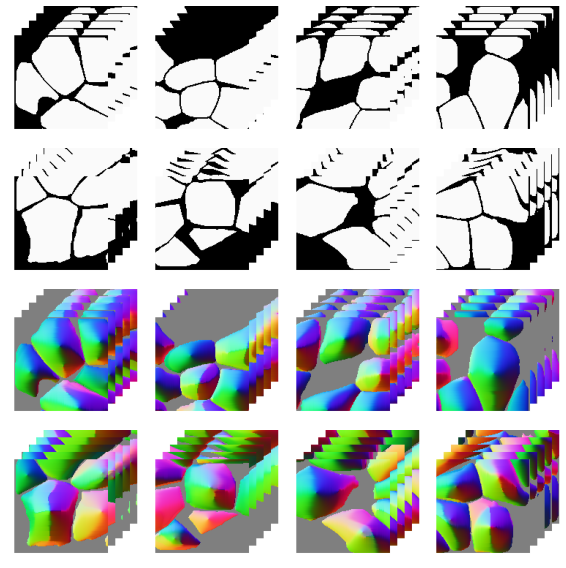

In [26]:
# training patches

mask_new = make_3d_image_3d(255*mask_minus_edges,50,50,dtype=np.uint8,d_step=10,Nstep=5)
flow_x_new = make_3d_image_3d(flow_x,50,50,dtype=np.uint8,d_step=10,Nstep=5)
flow_y_new = make_3d_image_3d(flow_y,50,50,dtype=np.uint8,d_step=10,Nstep=5)
flow_z_new = make_3d_image_3d(flow_z,50,50,slice=40,dtype=np.uint8)
# flow_x_new = make_3d_image_3d(flow_x,50,50,dtype=np.float64,d_step=10,Nstep=5)
# flow_y_new = make_3d_image_3d(flow_y,50,50,dtype=np.float64,d_step=10,Nstep=5)
# flow_z_new = make_3d_image_3d(flow_z,50,50,slice=40,dtype=np.float64)
row = 4
col = 4
step = 128

mask_p1 = make_3d_image_3d(250*mask_minus_edges[:,:128,:128],50,50,dtype=np.uint8,d_step=10,Nstep=5)
mask_p2 = make_3d_image_3d(250*mask_minus_edges[:,:128,128*1:128*2],50,50,dtype=np.uint8,d_step=10,Nstep=5)
mask_p3 = make_3d_image_3d(250*mask_minus_edges[:,:128,128*2:128*3],50,50,dtype=np.uint8,d_step=10,Nstep=5)
mask_p4 = make_3d_image_3d(250*mask_minus_edges[:,:128,128*3:128*4],50,50,dtype=np.uint8,d_step=10,Nstep=5)

fig,ax = plt.subplots(row ,col, figsize=(8,8))
ax[0][0].imshow(mask_p1,cmap='gray')
ax[0][1].imshow(mask_p2,cmap='gray')
ax[0][2].imshow(mask_p3,cmap='gray')
ax[0][3].imshow(mask_p4,cmap='gray')
# #-------------------------------


# ax[0][5].imshow(flowx_p1,cmap='gray')
# ax[0][6].imshow(flowx_p2,cmap='gray')
# ax[0][7].imshow(flowx_p3,cmap='gray')
# ax[0][8].imshow(flowx_p4,cmap='gray')
#-------------------------------------------------------
mask_p5 = make_3d_image_3d(250*mask_minus_edges[:,128*3:,:128],50,50,dtype=np.uint8,d_step=10,Nstep=5)
mask_p6 = make_3d_image_3d(250*mask_minus_edges[:,128*3:,128*1:128*2],50,50,dtype=np.uint8,d_step=10,Nstep=5)
mask_p7 = make_3d_image_3d(250*mask_minus_edges[:,128*3:,128*2:128*3],50,50,dtype=np.uint8,d_step=10,Nstep=5)
mask_p8 = make_3d_image_3d(250*mask_minus_edges[:,128*3:,128*3:128*4],50,50,dtype=np.uint8,d_step=10,Nstep=5)


ax[1][0].imshow(mask_p5,cmap='gray')
ax[1][1].imshow(mask_p6,cmap='gray')
ax[1][2].imshow(mask_p7,cmap='gray')
ax[1][3].imshow(mask_p8,cmap='gray')


flowx_p1 = make_3d_image_3d(flow_x[:,:128,:128],50,50,dtype=np.uint8,d_step=10,Nstep=5)
flowx_p2 = make_3d_image_3d(flow_x[:,:128,128*1:128*2],50,50,dtype=np.uint8,d_step=10,Nstep=5)
flowx_p3 = make_3d_image_3d(flow_x[:,:128,128*2:128*3],50,50,dtype=np.uint8,d_step=10,Nstep=5)
flowx_p4 = make_3d_image_3d(flow_x[:,:128,128*3:128*4],50,50,dtype=np.uint8,d_step=10,Nstep=5)
flowx_p5 = make_3d_image_3d(flow_x[:,128*3:,:128],50,50,dtype=np.uint8,d_step=10,Nstep=5)
flowx_p6 = make_3d_image_3d(flow_x[:,128*3:,128*1:128*2],50,50,dtype=np.uint8,d_step=10,Nstep=5)
flowx_p7 = make_3d_image_3d(flow_x[:,128*3:,128*2:128*3],50,50,dtype=np.uint8,d_step=10,Nstep=5)
flowx_p8 = make_3d_image_3d(flow_x[:,128*3:,128*3:128*4],50,50,dtype=np.uint8,d_step=10,Nstep=5)

flowy_p1 = make_3d_image_3d(flow_y[:,:128,:128],50,50,dtype=np.uint8,d_step=10,Nstep=5)
flowy_p2 = make_3d_image_3d(flow_y[:,:128,128*1:128*2],50,50,dtype=np.uint8,d_step=10,Nstep=5)
flowy_p3 = make_3d_image_3d(flow_y[:,:128,128*2:128*3],50,50,dtype=np.uint8,d_step=10,Nstep=5)
flowy_p4 = make_3d_image_3d(flow_y[:,:128,128*3:128*4],50,50,dtype=np.uint8,d_step=10,Nstep=5)
flowy_p5 = make_3d_image_3d(flow_y[:,128*3:,:128],50,50,dtype=np.uint8,d_step=10,Nstep=5)
flowy_p6 = make_3d_image_3d(flow_y[:,128*3:,128*1:128*2],50,50,dtype=np.uint8,d_step=10,Nstep=5)
flowy_p7 = make_3d_image_3d(flow_y[:,128*3:,128*2:128*3],50,50,dtype=np.uint8,d_step=10,Nstep=5)
flowy_p8 = make_3d_image_3d(flow_y[:,128*3:,128*3:128*4],50,50,dtype=np.uint8,d_step=10,Nstep=5)

flowz_p1 = make_3d_image_3d(flow_z[:,:128,:128],50,50,dtype=np.uint8,d_step=10,Nstep=5)
flowz_p2 = make_3d_image_3d(flow_z[:,:128,128*1:128*2],50,50,dtype=np.uint8,d_step=10,Nstep=5)
flowz_p3 = make_3d_image_3d(flow_z[:,:128,128*2:128*3],50,50,dtype=np.uint8,d_step=10,Nstep=5)
flowz_p4 = make_3d_image_3d(flow_z[:,:128,128*3:128*4],50,50,dtype=np.uint8,d_step=10,Nstep=5)
flowz_p5 = make_3d_image_3d(flow_z[:,128*3:,:128],50,50,dtype=np.uint8,d_step=10,Nstep=5)
flowz_p6 = make_3d_image_3d(flow_z[:,128*3:,128*1:128*2],50,50,dtype=np.uint8,d_step=10,Nstep=5)
flowz_p7 = make_3d_image_3d(flow_z[:,128*3:,128*2:128*3],50,50,dtype=np.uint8,d_step=10,Nstep=5)
flowz_p8 = make_3d_image_3d(flow_z[:,128*3:,128*3:128*4],50,50,dtype=np.uint8,d_step=10,Nstep=5)


flow_color_stack_p1 = np.moveaxis([flowz_p1,flowx_p1,flowy_p1], 0, -1)
flow_color_stack_p2 = np.moveaxis([flowz_p2,flowx_p2,flowy_p2], 0, -1)
flow_color_stack_p3 = np.moveaxis([flowz_p3,flowx_p3,flowy_p3], 0, -1)
flow_color_stack_p4 = np.moveaxis([flowz_p4,flowx_p4,flowy_p4], 0, -1)
flow_color_stack_p5 = np.moveaxis([flowz_p5,flowx_p5,flowy_p5], 0, -1)
flow_color_stack_p6 = np.moveaxis([flowz_p6,flowx_p6,flowy_p6], 0, -1)
flow_color_stack_p7 = np.moveaxis([flowz_p7,flowx_p7,flowy_p7], 0, -1)
flow_color_stack_p8 = np.moveaxis([flowz_p8,flowx_p8,flowy_p8], 0, -1)


ax[2][0].imshow(flow_color_stack_p1)
ax[2][1].imshow(flow_color_stack_p2)
ax[2][2].imshow(flow_color_stack_p3)
ax[2][3].imshow(flow_color_stack_p4)

ax[3][0].imshow(flow_color_stack_p5)
ax[3][1].imshow(flow_color_stack_p6)
ax[3][2].imshow(flow_color_stack_p7)
ax[3][3].imshow(flow_color_stack_p8)
# ax[1][6].imshow(flowx_p6,cmap='gray')
# ax[1][7].imshow(flowx_p7,cmap='gray')
# ax[1][8].imshow(flowx_p8,cmap='gray')



for i in range(row): 
    for j in range(col):
        ax[i][j].axis('off')

fig.tight_layout()

(3, 307, 307) (307, 307, 3)


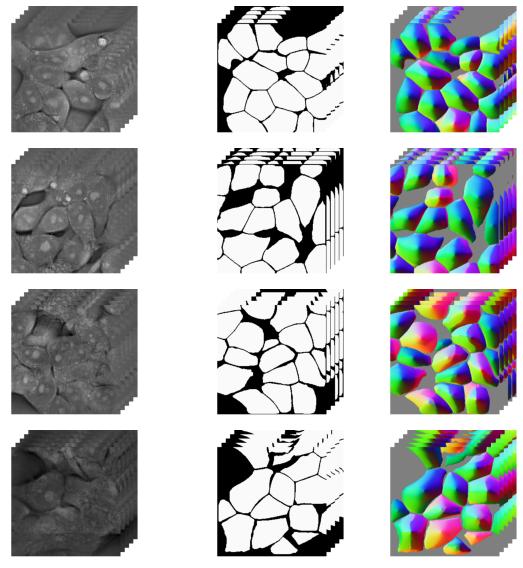

In [59]:
# training patches, try to make patches biggggger
# NEED TO Modify, this block is the same as the above one.
raw_image = tifffile.imread(raw_image_files[file_idx])


# mask_new = make_3d_image_3d(255*mask_minus_edges,50,50,dtype=np.uint8,d_step=10,Nstep=5)
# flow_x_new = make_3d_image_3d(flow_x,50,50,dtype=np.uint8,d_step=10,Nstep=5)
# flow_y_new = make_3d_image_3d(flow_y,50,50,dtype=np.uint8,d_step=10,Nstep=5)
# flow_z_new = make_3d_image_3d(flow_z,50,50,slice=40,dtype=np.uint8)
# flow_x_new = make_3d_image_3d(flow_x,50,50,dtype=np.float64,d_step=10,Nstep=5)
# flow_y_new = make_3d_image_3d(flow_y,50,50,dtype=np.float64,d_step=10,Nstep=5)
# flow_z_new = make_3d_image_3d(flow_z,50,50,slice=40,dtype=np.float64)
row = 4
col = 4
step = 128

raw_p1= make_3d_image_3d(3.5*raw_image[:,:256,:256],50,50,dtype=np.uint16,d_step=10,Nstep=5,slice= 30)
raw_p2= make_3d_image_3d(3.5*raw_image[:,:256,256:],50,50,dtype=np.uint16,d_step=10,Nstep=5,slice= 30)
raw_p3= make_3d_image_3d(3.5*raw_image[:,256:,:256],50,50,dtype=np.uint16,d_step=10,Nstep=5,slice= 25)
raw_p4= make_3d_image_3d(3.5*raw_image[:,256:,256:],50,50,dtype=np.uint16,d_step=10,Nstep=5,slice= 30)

mask_p1 = make_3d_image_3d(250*mask_minus_edges[:,:256,:256],50,50,dtype=np.uint8,d_step=10,Nstep=5)
mask_p2 = make_3d_image_3d(250*mask_minus_edges[:,:256,256:],50,50,dtype=np.uint8,d_step=10,Nstep=5)
mask_p3 = make_3d_image_3d(250*mask_minus_edges[:,256:,:256],50,50,dtype=np.uint8,d_step=10,Nstep=5)
mask_p4 = make_3d_image_3d(250*mask_minus_edges[:,256:,256:],50,50,dtype=np.uint8,d_step=10,Nstep=5)



#--------------------------make flows-------------------------------
flowx_p1 = make_3d_image_3d(flow_x[:,:256,:256],50,50,dtype=np.uint8,d_step=10,Nstep=5)
flowx_p2 = make_3d_image_3d(flow_x[:,:256,256:],50,50,dtype=np.uint8,d_step=10,Nstep=5)
flowx_p3 = make_3d_image_3d(flow_x[:,256:,:256],50,50,dtype=np.uint8,d_step=10,Nstep=5)
flowx_p4 = make_3d_image_3d(flow_x[:,256:,256:],50,50,dtype=np.uint8,d_step=10,Nstep=5)


flowy_p1 = make_3d_image_3d(flow_y[:,:256,:256],50,50,dtype=np.uint8,d_step=10,Nstep=5)
flowy_p2 = make_3d_image_3d(flow_y[:,:256,256:],50,50,dtype=np.uint8,d_step=10,Nstep=5)
flowy_p3 = make_3d_image_3d(flow_y[:,256:,:256],50,50,dtype=np.uint8,d_step=10,Nstep=5)
flowy_p4 = make_3d_image_3d(flow_y[:,256:,256:],50,50,dtype=np.uint8,d_step=10,Nstep=5)

flowz_p1 = make_3d_image_3d(flow_z[:,:256,:256],50,50,dtype=np.uint8,d_step=10,Nstep=5)
flowz_p2 = make_3d_image_3d(flow_z[:,:256,256:],50,50,dtype=np.uint8,d_step=10,Nstep=5)
flowz_p3 = make_3d_image_3d(flow_z[:,256:,:256],50,50,dtype=np.uint8,d_step=10,Nstep=5)
flowz_p4 = make_3d_image_3d(flow_z[:,256:,256:],50,50,dtype=np.uint8,d_step=10,Nstep=5)


flow_color_stack_p1 = np.moveaxis([flowz_p1,flowx_p1,flowy_p1], 0, -1)
flow_color_stack_p2 = np.moveaxis([flowz_p2,flowx_p2,flowy_p2], 0, -1)
flow_color_stack_p3 = np.moveaxis([flowz_p3,flowx_p3,flowy_p3], 0, -1)
flow_color_stack_p4 = np.moveaxis([flowz_p4,flowx_p4,flowy_p4], 0, -1)

#-----------------------------------------------------------------------------------------
fig,ax = plt.subplots(row ,col, figsize=(8,8),gridspec_kw={'width_ratios': [1, 0.2, 1,1]})
# ax[0][0].imshow(mask_p1,cmap='gray')
ax[0][0].imshow(raw_p1,cmap='gray')

ax[0][2].imshow(mask_p1,cmap='gray')
ax[0][3].imshow(flow_color_stack_p1,cmap='gray')
#-------------------------------------------------------

ax[1][0].imshow(raw_p2,cmap='gray')

ax[1][2].imshow(mask_p2,cmap='gray')
ax[1][3].imshow(flow_color_stack_p2,cmap='gray')


ax[2][0].imshow(raw_p4,cmap='gray')

ax[2][2].imshow(mask_p4,cmap='gray')
ax[2][3].imshow(flow_color_stack_p4,cmap='gray')


ax[3][0].imshow(raw_p3,cmap='gray')

ax[3][2].imshow(mask_p3,cmap='gray')
ax[3][3].imshow(flow_color_stack_p3,cmap='gray')



for i in range(row): 
    for j in range(col):
        ax[i][j].axis('off')

fig.tight_layout()

In [5]:
# make a phontom to illustrate SW MSA, not finished 
import tifffile 

image = tifffile.imread('/data/nanolive/phantom_for_SW_MSA_image1_big.tiff')
print(image.shape)
# stacked_img = np.stack((img,)*3, axis=-1)
# z,x,y,c = stacked_img.shape


import numpy as np

def insert_blocks_with_zeros(image, block_width):
    """
    Insert blocks filled with 0s into the image.

    Parameters:
        image (np.ndarray): 3D input image.
        block_width (int): Width of the inserted block.

    Returns:
        np.ndarray: New image with inserted blocks.
    """

    pad = 20
    new_shape = (image.shape[0] + pad, image.shape[1] , image.shape[2] )

    # Create a new array filled with zeros
    padded_image = np.zeros(new_shape, dtype=image.dtype)
    start_idx = int(image.shape[0]//2)

    padded_image[:start_idx] = image[:start_idx]
    padded_image[start_idx+pad:] = image[start_idx:]

    image = padded_image
    #------------------------------------------------
    new_shape = (image.shape[0] , image.shape[1] +pad , image.shape[2] )
    padded_image = np.zeros(new_shape, dtype=image.dtype)
    start_idx = int(image.shape[1]//2)

    padded_image[:,:start_idx] = image[:,:start_idx]
    padded_image[:,start_idx+pad:] = image[:,start_idx:]
    image = padded_image
    #------------------------------------------------
    new_shape = (image.shape[0], image.shape[1]  , image.shape[2] +pad )
    padded_image = np.zeros(new_shape, dtype=image.dtype)
    start_idx = int(image.shape[2]//2)

    padded_image[:,:,:start_idx] = image[:,:,:start_idx]
    padded_image[:,:,start_idx+pad:] = image[:,:,start_idx:]
    # image = padded_image
    
    return padded_image

# Example usage
# input_image = np.random.rand(64, 64, 64)  # Replace with your input image
block_width = 16  # Width of inserted block
output_image = insert_blocks_with_zeros(image, block_width)
colored_mask = np.zeros(output_image.shape, dtype=image.dtype)
#outline boundaries
colored_mask[0,0,:int(image.shape[2]//2)] = 255
colored_mask[0,0,-int(image.shape[2]//2):] = 255

colored_mask[-1,0,:int(image.shape[2]//2)] = 255
colored_mask[-1,0,-int(image.shape[2]//2):] = 255

colored_mask[0,-1,:int(image.shape[2]//2)] = 255
colored_mask[0,-1,-int(image.shape[2]//2):] = 255

colored_mask[-1,-1,:int(image.shape[2]//2)] = 255
colored_mask[-1,-1,-int(image.shape[2]//2):] = 255

# colored_mask[int(image.shape[0]//2),-1,:int(image.shape[2]//2)] = 255
# colored_mask[-int(image.shape[0]//2),-1,:int(image.shape[2]//2)] = 255

colored_mask[-1,-1,-int(image.shape[2]//2):] = 255
#-----------------------------------------------------------

colored_mask[0,:int(image.shape[1]//2),0] = 255
colored_mask[0,-int(image.shape[1]//2):,0] = 255

colored_mask[0,:int(image.shape[1]//2),-1] = 255
colored_mask[0,-int(image.shape[1]//2):,-1] = 255

colored_mask[0,:int(image.shape[1]//2),int(image.shape[2]//2)-1] = 255
colored_mask[0,:int(image.shape[1]//2),-int(image.shape[2]//2)+1] = 255

colored_mask[0,-int(image.shape[1]//2):,int(image.shape[2]//2)-1] = 255
colored_mask[0,-int(image.shape[1]//2):,-int(image.shape[2]//2)+1] = 255

colored_mask[0,int(image.shape[1]//2)-1,:int(image.shape[2]//2)] = 255
colored_mask[0,int(image.shape[1]//2)-1,-int(image.shape[2]//2):] = 255

colored_mask[0,-int(image.shape[1]//2)-1,:int(image.shape[2]//2)] = 255
colored_mask[0,-int(image.shape[1]//2)-1,-int(image.shape[2]//2):] = 255

colored_mask[-1,:int(image.shape[1]//2),0] = 255
colored_mask[-1,-int(image.shape[1]//2):,0] = 255

colored_mask[-1,:int(image.shape[1]//2),-1] = 255
colored_mask[-1,-int(image.shape[1]//2):,-1] = 255

#-------------------------------------------------------
colored_mask[:int(image.shape[0]//2),0,0] = 255
colored_mask[-int(image.shape[0]//2):,0,0] = 255

colored_mask[:int(image.shape[0]//2),-1,0] = 255
colored_mask[-int(image.shape[0]//2):,-1,0] = 255

colored_mask[:int(image.shape[0]//2),-1,-1] = 255
colored_mask[-int(image.shape[0]//2):,-1,-1] = 255

colored_mask[:int(image.shape[0]//2),0,-1] = 255
colored_mask[-int(image.shape[0]//2):,0,-1] = 255





# colored_mask[-1,:,:] = 255
# colored_mask[:,0,:] = 255
# colored_mask[:,-1,:]= 255

# colored_mask[:,:,0] =255
# colored_mask[:,:,-1]=255
print(colored_mask.shape)
# tifffile.imwrite('color_mask.tiff',colored_mask)
# tifffile.imwrite('output_image.tiff',output_image)
# tifffile.imwrite('padded_image.tiff',output_image,metadata={'axes': 'ZYX'})



(96, 332, 316)
(116, 352, 336)


In [ ]:
def make_3d_image_3d_v2(image,shiftx,shifty,d_step=10,slice=40,Nstep=5,dtype=np.uint16):
    m,n = image.shape[1:]
    new_image = np.ones((m+shiftx+1,n+shifty+1),dtype=dtype)*np.iinfo(dtype).max
    # new_image = np.ones((m+shiftx+1,n+shifty+1),dtype=dtype)
    for i in range(Nstep,0,-1):
        dx = shiftx -d_step*i
        dy = d_step*i
        new_image[dx:dx+m,dy:dy+n] = image[slice-2*i]
    return new_image

65535 0
255 22


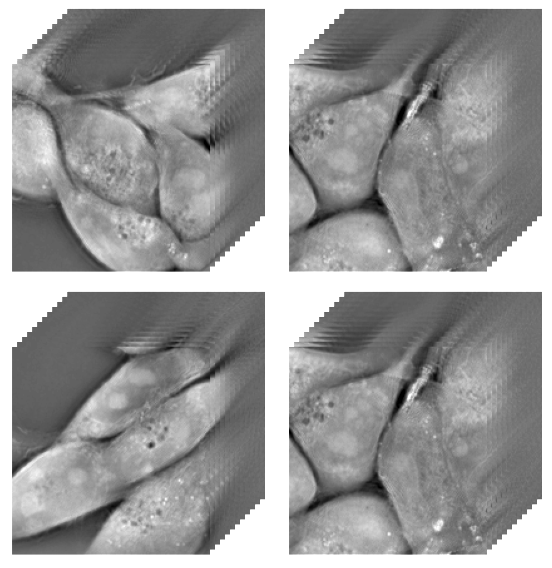

In [6]:
# make a phontom to illustrate SW MSA, not finished 
import tifffile 
import numpy as np
import matplotlib.pyplot as plt
# image = tifffile.imread('/data/nanolive/phantom_for_SW_MSA_image17_big.tiff')
image = tifffile.imread('/data/nanolive/phantom_for_SW_MSA_image1_big.tiff')
print(image.max(),image.min())
row = 2
col = 2
# print(image.shape)
image = np.uint8(image/256)
z,x,y = image.shape
fig,ax = plt.subplots(row ,col, figsize=(8,8))

mask_p1 = make_3d_image_3d(image[:,:x//2,:y//2],50,50,dtype=np.uint8,d_step=4,Nstep=12)
mask_p2 = make_3d_image_3d(image[:,:x//2,y//2:],50,50,dtype=np.uint8,d_step=4,Nstep=12)
mask_p3 = make_3d_image_3d(image[:,x//2:,:y//2],50,50,dtype=np.uint8,d_step=4,Nstep=12)
mask_p4 = make_3d_image_3d(image[:,:x//2,y//2:],50,50,dtype=np.uint8,d_step=4,Nstep=12)
print(mask_p1.max(),mask_p1.min())
vmin = 30
vmax = 180
ax[0][0].imshow(mask_p1,cmap='gray',vmin=vmin,vmax=vmax)
ax[0][1].imshow(mask_p2,cmap='gray',vmin=vmin,vmax=vmax)
ax[1][0].imshow(mask_p3,cmap='gray',vmin=vmin,vmax=vmax)
ax[1][1].imshow(mask_p4,cmap='gray',vmin=vmin,vmax=vmax)

for i in range(row): 
    for j in range(col):
        ax[i][j].axis('off')

fig.tight_layout()





65535 0
255 22


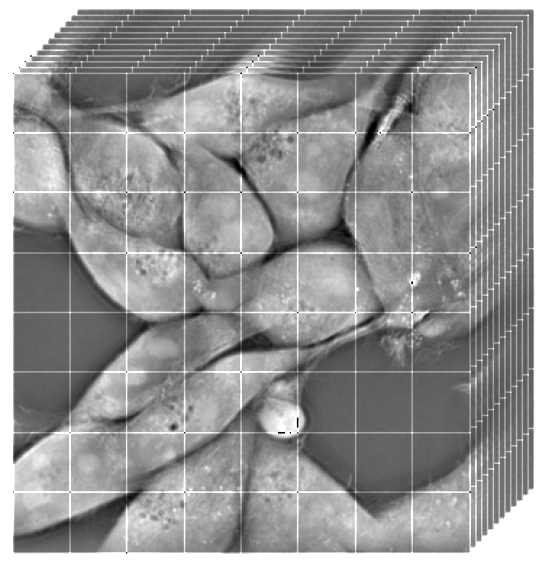

In [7]:
# make a phontom to illustrate SW MSA, not finished 
import tifffile 
# image = tifffile.imread('/data/nanolive/phantom_for_SW_MSA_image17_big.tiff')
image = tifffile.imread('/data/nanolive/phantom_for_SW_MSA_image1_big.tiff')
print(image.max(),image.min())

# print(image.shape)
image = np.uint8(image/256)
z,x,y = image.shape
width = 4

for j in np.linspace(0,x-1,9):
    j = int(j)
    image[:,j,:] = 1.5*image[:,j,:]

for k in np.linspace(0,y-1,9):
    k = int(k)
    image[:,:,k] = 1.5*image[:,:,k]


fig,ax = plt.subplots(1 ,1, figsize=(8,8))

image1 = make_3d_image_3d(image[:,:,:],50,50,dtype=np.uint8,d_step=4,Nstep=12)
print(mask_p1.max(),mask_p1.min())
# vmin = 30
# vmax = 180
ax.imshow(image1,cmap='gray',vmin=vmin,vmax=vmax)

ax.axis('off')
fig.tight_layout()

255 0


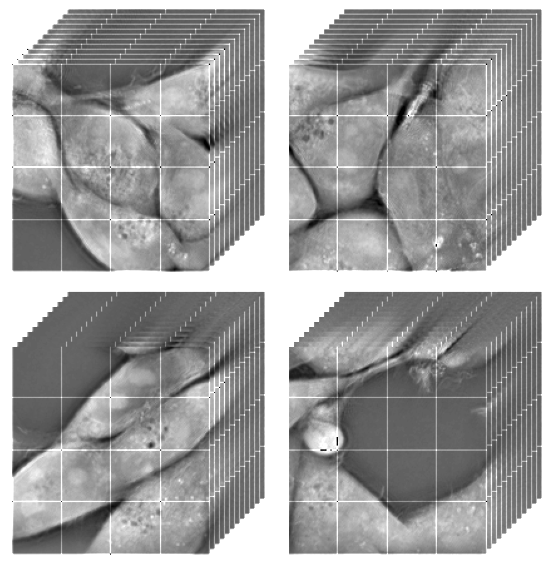

In [8]:
row = 2
col = 2
fig,ax = plt.subplots(row ,col, figsize=(8,8))

mask_p1 = make_3d_image_3d(image[:,:x//2,:y//2],50,50,dtype=np.uint8,d_step=4,Nstep=12)
mask_p2 = make_3d_image_3d(image[:,:x//2,y//2:],50,50,dtype=np.uint8,d_step=4,Nstep=12)
mask_p3 = make_3d_image_3d(image[:,x//2:,:y//2],50,50,dtype=np.uint8,d_step=4,Nstep=12)
mask_p4 = make_3d_image_3d(image[:,x//2:,y//2:],50,50,dtype=np.uint8,d_step=4,Nstep=12)
print(mask_p1.max(),mask_p1.min())
vmin = 30
vmax = 180
ax[0][0].imshow(mask_p1,cmap='gray',vmin=vmin,vmax=vmax)
ax[0][1].imshow(mask_p2,cmap='gray',vmin=vmin,vmax=vmax)
ax[1][0].imshow(mask_p3,cmap='gray',vmin=vmin,vmax=vmax)
ax[1][1].imshow(mask_p4,cmap='gray',vmin=vmin,vmax=vmax)

for i in range(row): 
    for j in range(col):
        ax[i][j].axis('off')

fig.tight_layout()


255 0


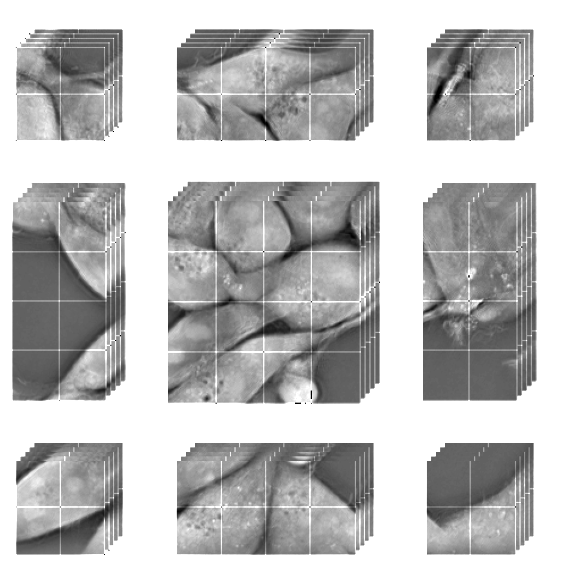

In [11]:
row = 3
col = 3
fig,ax = plt.subplots(row ,col, figsize=(8,8),gridspec_kw={'height_ratios': [1, 1.8, 1], 'width_ratios': [1, 1.8,1]})
Nstep = 5
shiftx =shifty =40
# print(x,y,z)
# print(x//4,int(x/4))
# print(3*x//4,int(3*x/4))
# print(np.linspace(0,x-1,8))
fig11 = make_3d_image_3d(image[:,:x//4,:y//4],shiftx,shifty,dtype=np.uint8,d_step=4,Nstep=Nstep)
fig12 = make_3d_image_3d(image[:,:x//4,y//4:3*y//4],shiftx,shifty,dtype=np.uint8,d_step=4,Nstep=Nstep)
fig13 = make_3d_image_3d(image[:,:x//4,3*y//4:],shiftx,shifty,dtype=np.uint8,d_step=4,Nstep=Nstep)

fig21 = make_3d_image_3d(image[:,x//4:3*x//4,:y//4],shiftx,shifty,dtype=np.uint8,d_step=4,Nstep=Nstep)
fig22 = make_3d_image_3d(image[:,x//4:3*x//4,y//4:3*y//4],shiftx,shifty,dtype=np.uint8,d_step=4,Nstep=Nstep)
fig23 = make_3d_image_3d(image[:,x//4:3*x//4,-y//4:],shiftx,shifty,dtype=np.uint8,d_step=4,Nstep=Nstep)

fig31  = make_3d_image_3d(image[:,3*x//4:,:y//4],shiftx,shifty,dtype=np.uint8,d_step=4,Nstep=Nstep)
fig32 = make_3d_image_3d(image[:,3*x//4:,y//4:3*y//4],shiftx,shifty,dtype=np.uint8,d_step=4,Nstep=Nstep)
fig33 = make_3d_image_3d(image[:,3*x//4:,-y//4:],shiftx,shifty,dtype=np.uint8,d_step=4,Nstep=Nstep)

print(fig11.max(),fig11.min())


ax[0][0].imshow(fig11,cmap='gray',vmin=vmin,vmax=vmax)
ax[0][1].imshow(fig12,cmap='gray',vmin=vmin,vmax=vmax)
ax[0][2].imshow(fig13,cmap='gray',vmin=vmin,vmax=vmax)

ax[1][0].imshow(fig21,cmap='gray',vmin=vmin,vmax=vmax)
ax[1][1].imshow(fig22,cmap='gray',vmin=vmin,vmax=vmax)
ax[1][2].imshow(fig23,cmap='gray',vmin=vmin,vmax=vmax)


ax[2][0].imshow(fig31,cmap='gray',vmin=vmin,vmax=vmax)
ax[2][1].imshow(fig32,cmap='gray',vmin=vmin,vmax=vmax)
ax[2][2].imshow(fig33,cmap='gray',vmin=vmin,vmax=vmax)
# ax[1][1].imshow(mask_p4,cmap='gray',vmin=vmin,vmax=vmax, alpha=0.8)

for i in range(row): 
    for j in range(col):
        ax[i][j].axis('off')

fig.tight_layout()

In [2]:
import tifffile 
path = '/home/xzhang/Projects/cellpose/Nanolive_mem_cellpose_data_v5_nor_1_99/'
image_path = '36_RI_time00h00m00s.tiff'
mask_path = 'cellpose_size_2500_36_RI_time00h00m00s_pred.tiff'
flow_path = 
# image = tifffile.imread('/data/nanolive/phantom_for_SW_MSA_image17_big.tiff')
image = tifffile.imread(path+image_path)
mask = tifffile.imread(path+mask_path)
print(image.max(),image.min())
print(mask.max(),mask.min())

255 0
30 0
